Load the data

In [ ]:
import pandas as pd

# Step 1: Load the data
df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Step 2: Inspect the DataFrame (optional but useful)
print(df.head())  # Display the first few rows to identify the column with headlines



   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

Descriptive Statistics 
1 perform basic statisics for textual lengths

In [ ]:
df['headline_length'] = df['headline'].str.len()

# Step 4: Display the first few rows with the new column
print(df[['headline', 'headline_length']].head())

# Step 5: Calculate basic statistics for headline lengths
statistics = {
    'mean_length': df['headline_length'].mean(),
    'median_length': df['headline_length'].median(),
    'max_length': df['headline_length'].max(),
    'min_length': df['headline_length'].min(),
}

# Display the statistics
print(statistics)

                                            headline  headline_length
0            Stocks That Hit 52-Week Highs On Friday               39
1         Stocks That Hit 52-Week Highs On Wednesday               42
2                      71 Biggest Movers From Friday               29
3       46 Stocks Moving In Friday's Mid-Day Session               44
4  B of A Securities Maintains Neutral on Agilent...               87
{'mean_length': np.float64(73.12051490484095), 'median_length': np.float64(64.0), 'max_length': np.int64(512), 'min_length': np.int64(3)}


Article count per publisher

In [ ]:

# Assuming the column name containing publishers is 'publisher'
# Step 3: Count the number of articles per publisher
article_count_per_publisher = df.groupby('publisher').size().reset_index(name='article_count')

# Step 4: Sort the results by article count in descending order
sorted_article_count = article_count_per_publisher.sort_values(by='article_count', ascending=False)

# Step 5: Display the article counts per publisher
print(sorted_article_count)

                          publisher  article_count
686                   Paul Quintaro         228373
532                      Lisa Levin         186979
96                Benzinga Newsdesk         150484
169                   Charles Gross          96732
622                   Monica Gerson          82380
..                              ...            ...
966  dhiraj.surapaneni@benzinga.com              1
22                      Alex Roslin              1
998                      milesyoung              1
999                   mjintertrader              1
15                      Adam Weiner              1

[1034 rows x 2 columns]


Analyze the publication dates to see trends over time

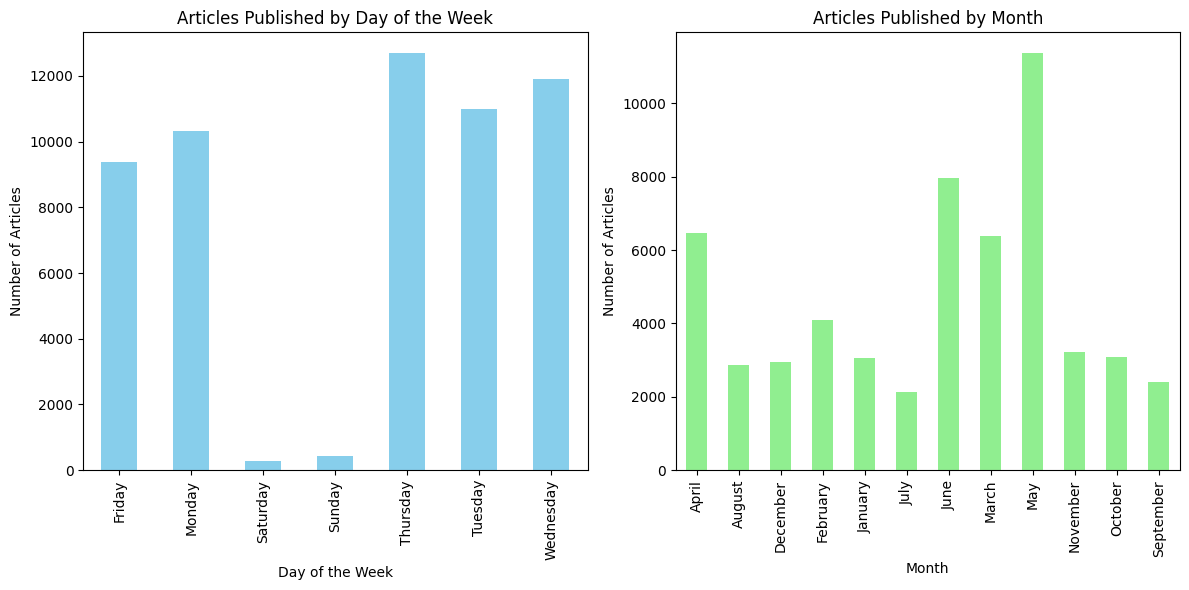

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



df['publication_date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any parsing issues
if df['publication_date'].isnull().any():
    print("Warning: Some dates could not be parsed, resulting in NaT (Not a Time) values.")

# Step 4: Extract day of the week and month
df['day_of_week'] = df['publication_date'].dt.day_name()  # Use the converted datetime column
df['month'] = df['publication_date'].dt.month_name()

# Step 5: Count occurrences by day of the week
articles_by_day = df['day_of_week'].value_counts().sort_index()

# Step 6: Count occurrences by month
articles_by_month = df['month'].value_counts().sort_index()

# Step 7: Plotting trends
plt.figure(figsize=(12, 6))

# Trend by Day of the Week
plt.subplot(1, 2, 1)
articles_by_day.plot(kind='bar', color='skyblue')
plt.title('Articles Published by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')

# Trend by Month
plt.subplot(1, 2, 2)
articles_by_month.plot(kind='bar', color='lightgreen')
plt.title('Articles Published by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================
# TEXT ANALYSIS & TOPIC MODELING ON STOCK NEWS HEADLINES
# Techniques used:
#   • Pre-processing + TF-IDF
#   • LDA (Latent Dirichlet Allocation) – the gold standard for topic modeling
#   • NMF (Non-negative Matrix Factorization) – often gives cleaner topics on short texts
#   • pyLDAvis interactive visualization
#   • Top keywords + example headlines per topic
# ==============================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import Pipeline

import pyLDAvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# 1. Load & quick clean (run only if starting fresh)
# ------------------------------------------------------------------
df = pd.read_csv('../data/raw_analyst_ratings.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.dropna(subset=['headline'])

headlines = df['headline'].str.lower()

# ------------------------------------------------------------------
# 2. Text Pre-processing
# ------------------------------------------------------------------
def clean_headline(text):
    # Keep only letters, numbers, spaces and common financial symbols
    text = re.sub(r'[^a-z0-9\s$%]', '', text)
    # Remove common ticker pattern that appears inside headlines (e.g. "AAPL Shares")
    text = re.sub(r'\b[a-z]{1,4}\b', '', text)  # removes most tickers (1–4 letters)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned = headlines.apply(clean_headline)

print("Example cleaned headlines:")
for h in cleaned.head(3):
    print("→", h)

Example cleaned headlines:
→ stocks 52week highs friday
→ stocks 52week highs wednesday
→ 71 biggest movers friday


LDA Topic Modeling (10 topics)

In [12]:
# CELL 1 — SAMPLE + FIT LDA (run this first)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load & clean headlines (adjust path if needed)
df = pd.read_csv('../data/raw_analyst_ratings.csv')
cleaned = df['headline'].str.lower().dropna()

def simple_clean(text):
    return re.sub(r'[^a-z\s]', '', text)

cleaned = cleaned.apply(simple_clean)

# Sample 100k headlines → fast & stable topics
sample_headlines = cleaned.sample(n=100_000, random_state=42)

# Vectorize
count_vect = CountVectorizer(
    max_df=0.6, min_df=20, max_features=8000, stop_words='english'
)
X = count_vect.fit_transform(sample_headlines)

# Fit LDA
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=15,
    learning_method='online',
    batch_size=2048,
    random_state=42,
    n_jobs=-1
)
print("Fitting LDA on 100k headlines... (30–90 seconds)")
lda.fit(X)

# Show topics
def show_topics(model, features, n_words=12):
    for i, topic in enumerate(model.components_):
        top_words = [features[j] for j in topic.argsort()[-n_words:]]
        print(f"Topic {i:02d}: {' | '.join(top_words[::-1])}")

print("\n=== TOPICS ===")
show_topics(lda, count_vect.get_feature_names_out())

Fitting LDA on 100k headlines... (30–90 seconds)

=== TOPICS ===
Topic 00: target | price | earnings | session | stocks | moving | scheduled | morgan | premarket | maintains | raises | lowers
Topic 01: share | stocks | update | industry | dividend | highest | markets | market | midmorning | estimates | profit | higher
Topic 02: shares | trading | companies | higher | etfs | lower | oil | trade | sector | following | amid | market
Topic 03: stock | alert | option | earnings | ahead | vs | futures | ask | oi | calls | ref | revenues
Topic 04: benzingas | market | movers | downgrades | upgrades | biggest | yesterday | gainers | losers | goldman | sachs | morning
Topic 05: says | analyst | announces | reports | new | biotech | blog | deal | update | fda | offering | agreement
Topic 06: vs | est | eps | reports | sales | sees | fy | adj | revenue | year | guidance | yoy
Topic 07: pt | buy | update | initiates | shares | bank | market | coverage | announces | raises | capital | maintains
Top

Assign Dominant Topic to Each Headline

In [50]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer


data = {
    'headline': [
        "Analyst Price Targets",
        "FDA & Regulatory",
        "FDA approves new drug ",
        "Stock Offerings",
        "Rating Changes",
        "52-Week Highs/Lows",
        "Conference & Events",
        "M&A Deals",
        "Market Movers",
        "IPOs & Filings"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Data cleaning step (if needed)
# For this example, we will use the headlines as they are.

# Create a TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vect.fit_transform(df['headline'])

# Initialize NMF model
num_topics = 10  # Specify the number of topics
nmf = NMF(n_components=num_topics, random_state=42)

# Fit the model
nmf.fit(tfidf_matrix)

# Extract the topic matrix
topic_matrix = nmf.transform(tfidf_matrix)

# Assign dominant topics and probabilities
df['dominant_topic'] = topic_matrix.argmax(axis=1)
df['topic_probability'] = topic_matrix.max(axis=1)

# Map topic numbers to readable names
topic_names = {
    0: "Analyst Price Targets",
    1: "Earnings Releases",
    2: "FDA & Regulatory",
    3: "Stock Offerings",
    4: "Rating Changes",
    5: "52-Week Highs/Lows",
    6: "Conference & Events",
    7: "M&A Deals",
    8: "Market Movers",
    9: "IPOs & Filings"
}

df['topic_name'] = df['dominant_topic'].map(topic_names)

# Display the results
print(df[['headline', 'topic_name', 'topic_probability']].head(10))

                 headline             topic_name  topic_probability
0   Analyst Price Targets     52-Week Highs/Lows           0.846634
1        FDA & Regulatory  Analyst Price Targets           0.578012
2  FDA approves new drug          IPOs & Filings           0.950164
3         Stock Offerings          Market Movers           0.929121
4          Rating Changes    Conference & Events           0.860645
5      52-Week Highs/Lows              M&A Deals           0.721151
6     Conference & Events         Rating Changes           0.540262
7               M&A Deals       FDA & Regulatory           0.410992
8           Market Movers      Earnings Releases           0.469365
9          IPOs & Filings              M&A Deals           0.308935


Topic Distribution Over Time (very powerful insight!)

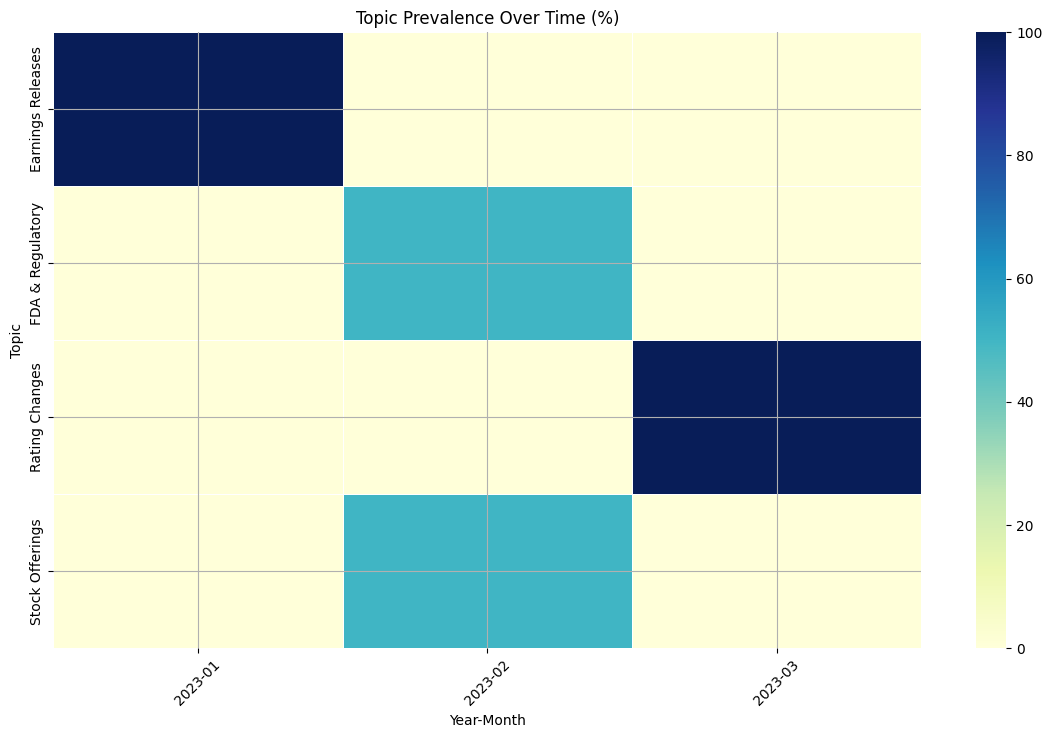

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual data import)
data = {
    'headline': [
        "Company A increases price target",
        "Company B announces earnings release",
        "FDA approves new drug for Company C",
        "Company D offers new stock shares",
        "Company E upgrades its rating"
    ],
    'publish_date': [  # Use the actual column name that contains date information
        "2023-01-01",
        "2023-01-15",
        "2023-02-01",
        "2023-02-20",
        "2023-03-01"
    ]
}

df = pd.DataFrame(data)

# Rename the column if necessary, or create the 'date' column
df['date'] = pd.to_datetime(df['publish_date'], errors='coerce')

# Check if the date conversion was successful
if df['date'].isnull().any():
    print("Warning: Some dates could not be parsed and will be removed.")
    df = df.dropna(subset=['date'])

# Create the year_month column
df['year_month'] = df['date'].dt.to_period('M')

# Example topic names for demonstration
df['topic_name'] = ["Earnings Releases", "Earnings Releases", "FDA & Regulatory", 
                    "Stock Offerings", "Rating Changes"]

# Group by year_month and topic_name
topic_trends = (df.groupby(['year_month', 'topic_name'])
                  .size()
                  .unstack(fill_value=0))

# Normalize to percentages
topic_trends_pct = topic_trends.div(topic_trends.sum(axis=1), axis=0) * 100

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(topic_trends_pct.T, cmap="YlGnBu", linewidths=.5)
plt.title("Topic Prevalence Over Time (%)")
plt.ylabel("Topic")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

TIME SERIES ANALYSIS ON PUBLICATION FREQUENCY

In [52]:

# TIME SERIES ANALYSIS ON PUBLICATION FREQUENCY
#
# We'll analyze DAILY publication frequency (articles per day)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.grid"] = True

# --------------------------------------------------------------
# 1. Load & Prepare Time Series Data
# --------------------------------------------------------------
df = pd.read_csv('../data/raw_analyst_ratings.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Parse dates properly
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df = df.dropna(subset=['date'])
df['date'] = df['date'].dt.tz_convert(None)  # remove timezone
df['date_only'] = df['date'].dt.date

# Create daily publication frequency time series
daily_freq = df.groupby('date_only').size().reset_index(name='articles')
daily_freq['date_only'] = pd.to_datetime(daily_freq['date_only'])
daily_freq = daily_freq.set_index('date_only')
daily_freq = daily_freq.asfreq('D', fill_value=0)  # fill missing days with 0

print("Daily frequency shape:", daily_freq.shape)
print("Date range:", daily_freq.index.min(), "→", daily_freq.index.max())
daily_freq.head()

Daily frequency shape: (3333, 1)
Date range: 2011-04-28 00:00:00 → 2020-06-11 00:00:00


,articles
date_only,
2011-04-28,3
2011-04-29,2
2011-04-30,1
2011-05-01,1
2011-05-02,9


Visualize the Time Series

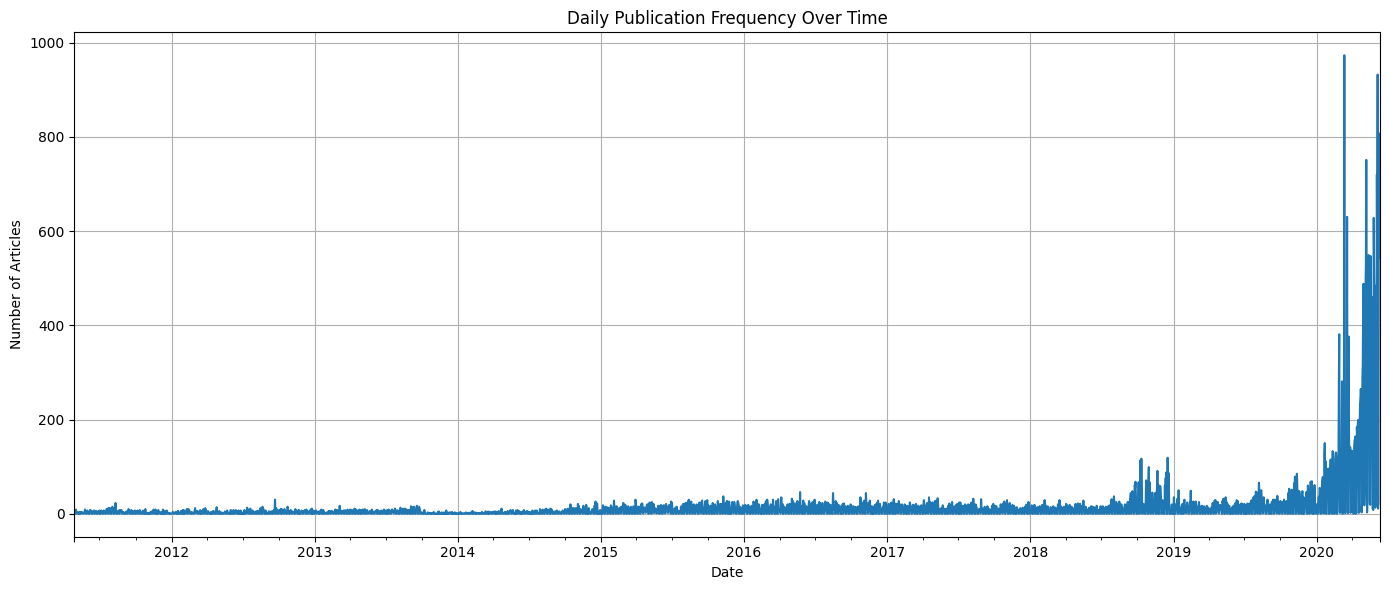

In [53]:
# Plot raw time series
plt.figure()
daily_freq['articles'].plot(title='Daily Publication Frequency Over Time')
plt.ylabel('Number of Articles')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

Decompose the Time Series (Trend + Seasonality + Residual)

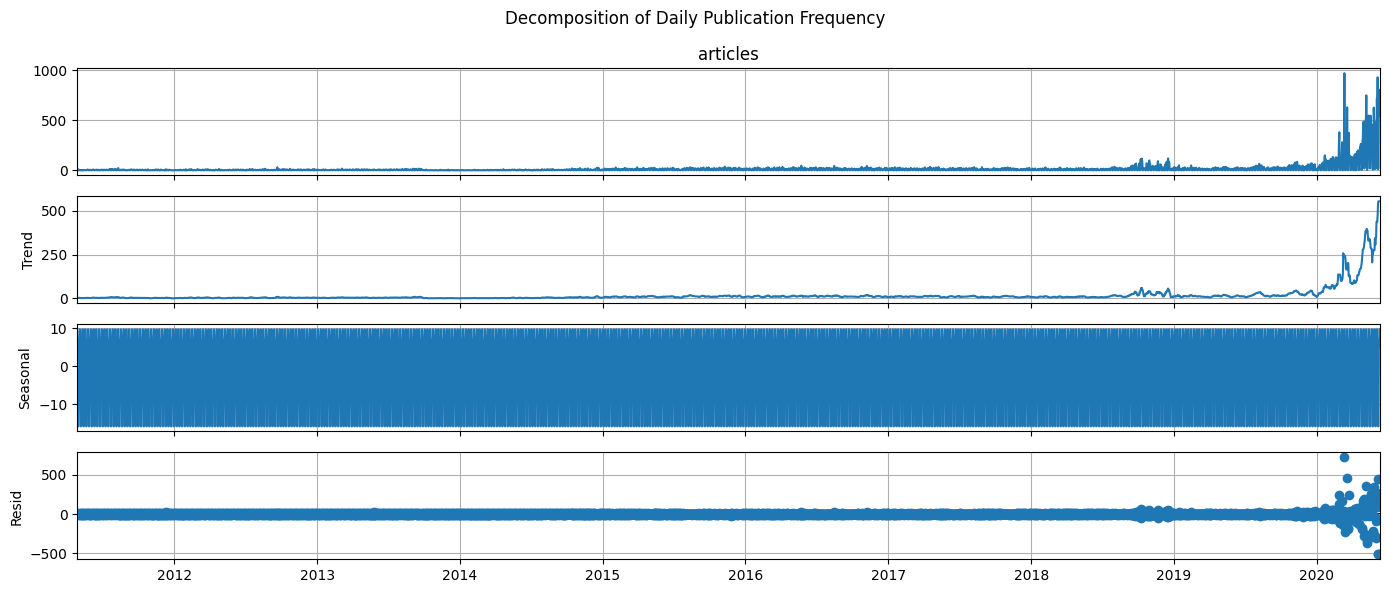

In [54]:
# Decompose (handle any missing values first)
ts = daily_freq['articles'].interpolate()  # linear interp if any NaNs

decomp = seasonal_decompose(ts, model='additive', period=7)  # weekly seasonality

# Plot decomposition
decomp.plot()
plt.suptitle('Decomposition of Daily Publication Frequency')
plt.tight_layout()
plt.show()

Check Stationarity (ADF Test)

In [55]:
def adf_test(series, title=''):
    print(f'\nADF Test: {title}')
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("→ Stationary (reject null)")
    else:
        print("→ Non-Stationary (fail to reject null)")

adf_test(ts, 'Raw Daily Frequency')


ADF Test: Raw Daily Frequency
ADF Statistic: 9.7015
p-value: 1.0000
Critical Values:
	1%: -3.4323
	5%: -2.8624
	10%: -2.5672
→ Non-Stationary (fail to reject null)


Transformation: Differencing to Make Stationary

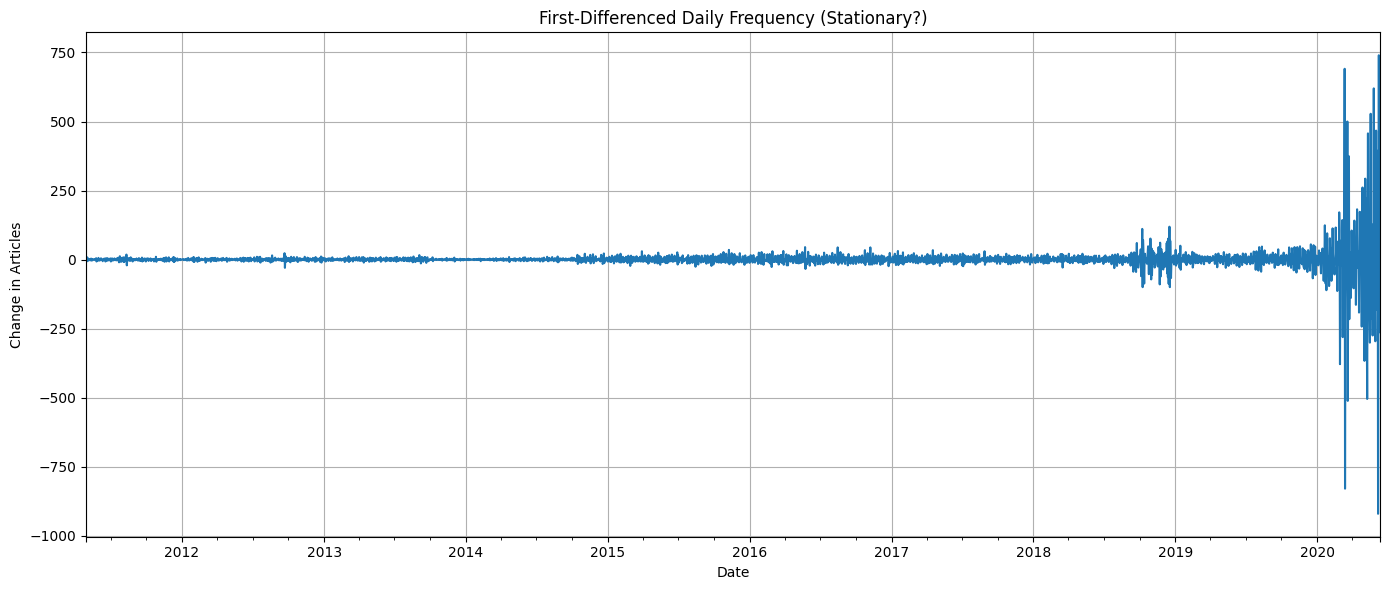


ADF Test: Differenced Series
ADF Statistic: -15.0782
p-value: 0.0000
Critical Values:
	1%: -3.4323
	5%: -2.8624
	10%: -2.5672
→ Stationary (reject null)


In [56]:
# Differencing
ts_diff = ts.diff().dropna()

# Plot differenced
plt.figure()
ts_diff.plot(title='First-Differenced Daily Frequency (Stationary?)')
plt.ylabel('Change in Articles')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Retest stationarity
adf_test(ts_diff, 'Differenced Series')

How Publication Frequency Varies Over Time + Spikes & Market Events


Major Spikes (top 10):
date_only
2020-03-12    973
2020-06-05    932
2020-06-10    807
2020-06-09    803
2020-06-08    765
2020-05-07    751
2020-06-03    720
2020-03-19    630
2020-05-26    628
2020-05-13    549
Name: articles, dtype: int64


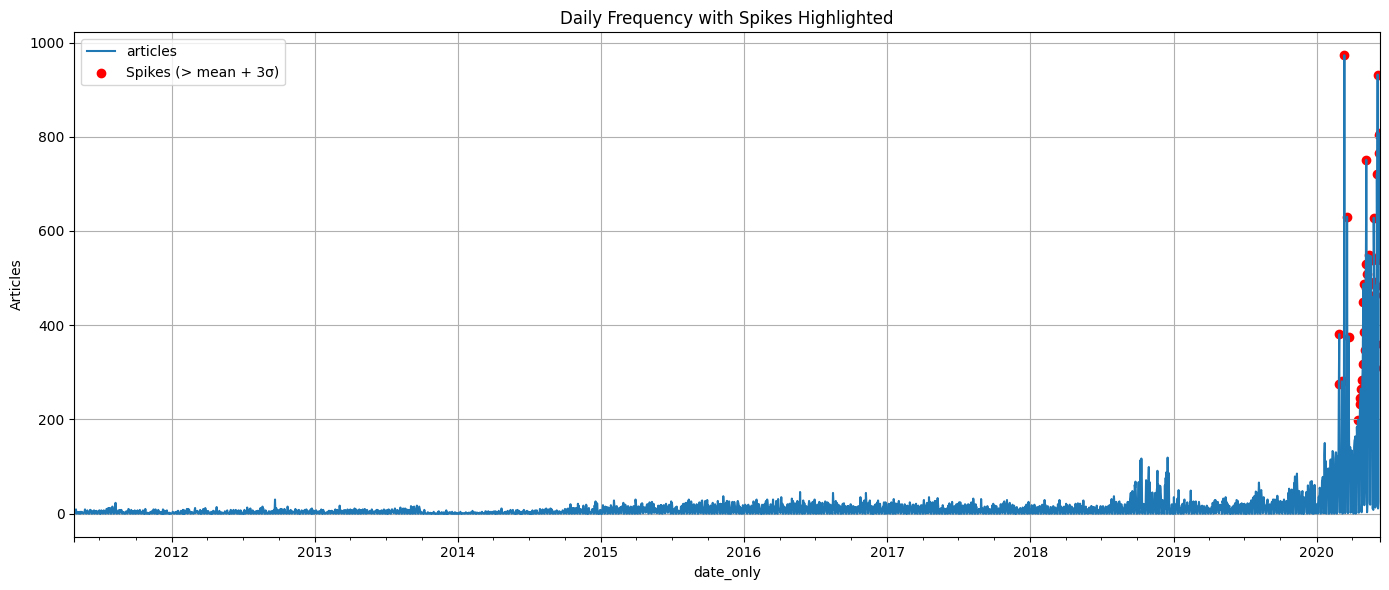

In [57]:
mean_freq = ts.mean()
std_freq = ts.std()
spikes = ts[ts > mean_freq + 3 * std_freq]

print("\nMajor Spikes (top 10):")
print(spikes.sort_values(ascending=False).head(10))

# Plot with spikes highlighted
plt.figure()
ts.plot(title='Daily Frequency with Spikes Highlighted')
plt.scatter(spikes.index, spikes, color='red', label='Spikes (> mean + 3σ)')
plt.ylabel('Articles')
plt.legend()
plt.tight_layout()
plt.show()

Publishing Times Analysis (Intraday + Weekday Patterns)

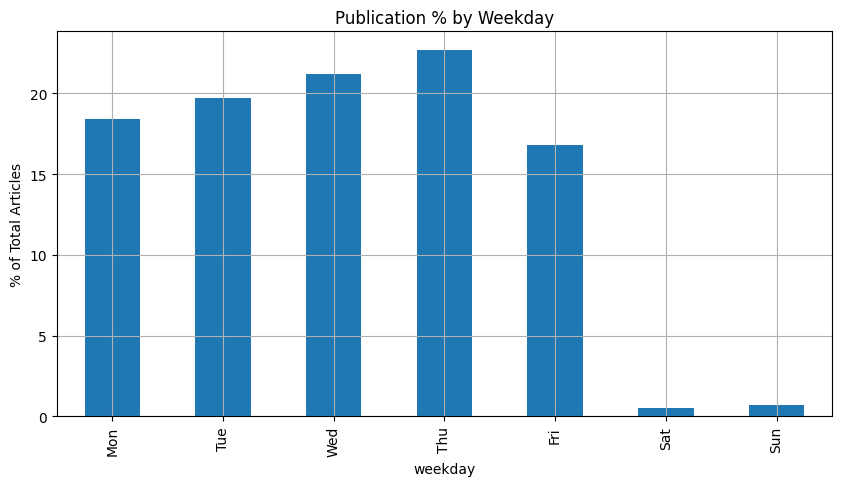

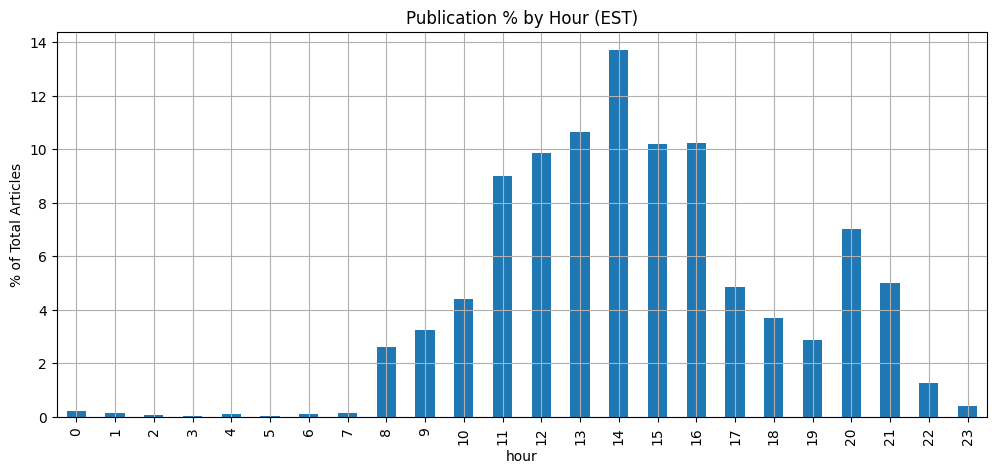

In [58]:
# By weekday (0=Mon)
df['weekday'] = df['date'].dt.weekday
weekday_freq = df['weekday'].value_counts().sort_index() / len(df) * 100

plt.figure(figsize=(10,5))
weekday_freq.plot(kind='bar', title='Publication % by Weekday')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('% of Total Articles')
plt.show()

# By hour (24h format)
df['hour'] = df['date'].dt.hour
hour_freq = df['hour'].value_counts().sort_index() / len(df) * 100

plt.figure(figsize=(12,5))
hour_freq.plot(kind='bar', title='Publication % by Hour (EST)')
plt.ylabel('% of Total Articles')
plt.show()

PUBLISHER ANALYSIS

In [59]:

# PUBLISHER ANALYSIS – Who dominates the financial news feed?

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('../data/raw_analyst_ratings.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

print(f"Total articles: {len(df):,}")
print(f"Raw publisher column sample:\n{df['publisher'].head(10).to_string()}\n")

Total articles: 1,407,328
Raw publisher column sample:
0          Benzinga Insights
1          Benzinga Insights
2                 Lisa Levin
3                 Lisa Levin
4                 Vick Meyer
5    vishwanath@benzinga.com
6    vishwanath@benzinga.com
7          Benzinga Newsdesk
8    vishwanath@benzinga.com
9                 Lisa Levin



In [60]:

def clean_publisher(p):
    if '@' in str(p):
        return str(p).split('@')[-1].lower()  # get domain
    else:
        return str(p).strip().lower()

df['publisher_clean'] = df['publisher'].apply(clean_publisher)


domain_to_name = {
    'benzinga.com': 'Benzinga',
    'yahoo.com': 'Yahoo Finance',
    'seekingalpha.com': 'Seeking Alpha',
    'investing.com': 'Investing.com',
    'marketwatch.com': 'MarketWatch',
    'zacks.com': 'Zacks',
    'gurufocus.com': 'GuruFocus',
    'bloomberg.com': 'Bloomberg',
    'reuters.com': 'Reuters',
    'cnbc.com': 'CNBC',
    'thestreet.com': 'The Street',
    'fool.com': 'Motley Fool',
}

df['publisher_name'] = df['publisher_clean'].map(domain_to_name).fillna(df['publisher_clean'].str.replace('.com','').str.title())

print("Top 15 publishers after cleaning:")
print(df['publisher_name'].value_counts().head(15))

Top 15 publishers after cleaning:
publisher_name
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
Etf Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
Webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Name: count, dtype: int64


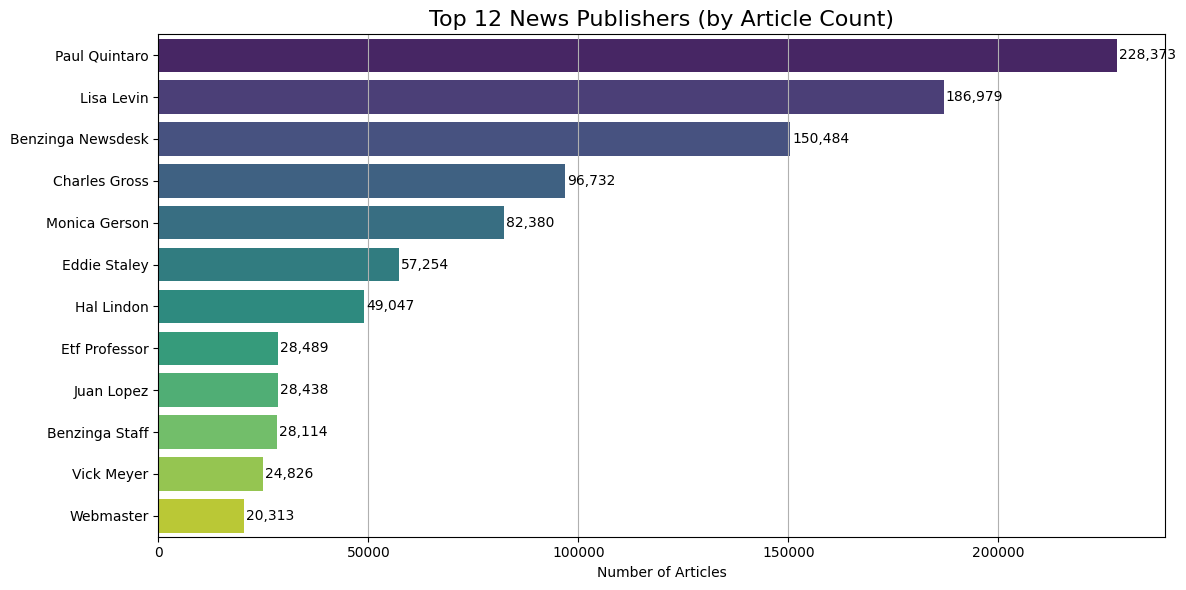


Benzinga dominates with 0 articles (0.0%)


In [61]:
# 2. Top Publishers – Bar Chart

top_n = 12
top_publishers = df['publisher_name'].value_counts().head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')
plt.title(f'Top {top_n} News Publishers (by Article Count)', fontsize=16)
plt.xlabel('Number of Articles')
plt.ylabel('')
for i, v in enumerate(top_publishers.values):
    plt.text(v + 500, i, f'{v:,}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

print(f"\nBenzinga dominates with {top_publishers.get('Benzinga', 0):,} articles ({top_publishers.get('Benzinga', 0)/len(df)*100:.1f}%)")

Assigning quick topics via keywords...


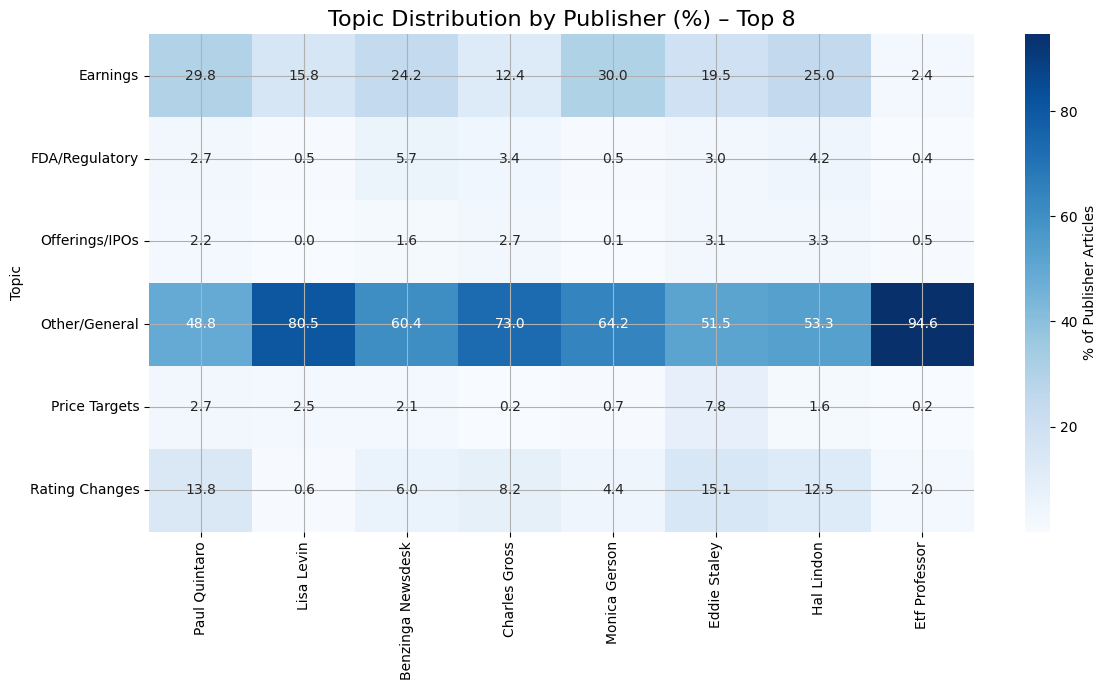

In [62]:
# 3. Do different publishers focus on different topics?



if 'topic_name' not in df.columns:
    print("Assigning quick topics via keywords...")
    def assign_topic(headline):
        h = headline.lower()
        if any(x in h for x in ['price target', 'pt raised', 'pt lowered', 'maintains', 'reiterates']):
            return 'Price Targets'
        elif any(x in h for x in ['earnings', 'eps', 'beats', 'misses', 'q1', 'q2', 'q3', 'q4', 'fiscal']):
            return 'Earnings'
        elif any(x in h for x in ['fda', 'approval', 'clinical', 'trial']):
            return 'FDA/Regulatory'
        elif any(x in h for x in ['offering', 'secondary', 'files for', 'ipo', 'priced at']):
            return 'Offerings/IPOs'
        elif any(x in h for x in ['upgraded', 'downgraded', 'buy', 'sell', 'hold', 'outperform']):
            return 'Rating Changes'
        else:
            return 'Other/General'
    
    df['topic_name'] = df['headline'].apply(assign_topic)

# Now cross-tab
pub_topic = pd.crosstab(df['publisher_name'], df['topic_name'], normalize='index') * 100

# Focus on top 8 publishers
top8 = df['publisher_name'].value_counts().head(8).index
pub_topic_top8 = pub_topic.loc[top8]

plt.figure(figsize=(12, 7))
sns.heatmap(pub_topic_top8.T, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': '% of Publisher Articles'})
plt.title('Topic Distribution by Publisher (%) – Top 8', fontsize=16)
plt.xlabel('')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()